# Particle Identification Notebook

We tackle the particle identification of neutrons and gamma-rays using LaBr3 detectors (gamma rays) and CLYC detecotrs (neutrons). It is critical to correctly identify the particles in order to perform the coincidence analysis. 

## Imports

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from DataFormat  import DataFormat
from read_data   import read_data
from calibration import read_calibration_parameters, linear_calibration

from sklearn.cluster import DBSCAN, OPTICS


## Constants

In [2]:
DATA_PATH   = "./data"
DATA_PREFIX = "beam-analysis-day"

LABR_A  = "labr-a"
LABR_B  = "labr-b"
CLYC    = "clyc"
PLASTIC = "plastic"

## Read data

In [3]:
run_day  = 2

data_labr_a = read_data(DATA_PATH, f"{DATA_PREFIX}{run_day}.root", DataFormat(LABR_A))
data_labr_b = read_data(DATA_PATH, f"{DATA_PREFIX}{run_day}.root", DataFormat(LABR_A))
data_clyc   = read_data(DATA_PATH, f"{DATA_PREFIX}{run_day}.root", DataFormat(CLYC))

In [4]:
# clean data from saturated events
data_labr_a = data_labr_a[data_labr_a["energy"] < data_labr_a["energy"].max()]
data_labr_b = data_labr_b[data_labr_b["energy"] < data_labr_b["energy"].max()]
data_clyc   = data_clyc[data_clyc["energy"] < data_clyc["energy"].max()]

# clean data from zero energy events
data_labr_a = data_labr_a[data_labr_a["energy"] > 0]
data_labr_b = data_labr_b[data_labr_b["energy"] > 0]
data_clyc   = data_clyc[data_clyc["energy"] > 0]

## Calibration

In [5]:
param_labr_a = read_calibration_parameters(
    "./calibration-parameters/labr_a_linear_parameters.txt"
)

param_labr_b = read_calibration_parameters(
    "./calibration-parameters/labr_b_linear_parameters.txt"
)

param_clyc = read_calibration_parameters(
    "./calibration-parameters/clyc_linear_parameters.txt"
)

In [6]:
data_labr_a.loc[:, "energy_calib"]       = linear_calibration(data_labr_a["energy"], param_labr_a)
data_labr_a.loc[:, "energy_short_calib"] = linear_calibration(data_labr_a["energy_short"], param_labr_a)

data_labr_b.loc[:, "energy_calib"]       = linear_calibration(data_labr_b["energy"], param_labr_b)
data_labr_b.loc[:, "energy_short_calib"] = linear_calibration(data_labr_b["energy_short"], param_labr_b)

data_clyc.loc[:,   "energy_calib"]       = linear_calibration(data_clyc["energy"], param_clyc)
data_clyc.loc[:,   "energy_short_calib"] = linear_calibration(data_clyc["energy_short"], param_clyc)

In [7]:
def compute_psd(df):
    return (df["energy"] - df["energy_short"]) / df["energy"]

def compute_psd_calib(df):
    return (df["energy_calib"] - df["energy_short_calib"]) / df["energy_calib"]

data_labr_a.loc[:, "psd"] = compute_psd(data_labr_a)
data_labr_b.loc[:, "psd"] = compute_psd(data_labr_b)
data_clyc.loc[:,   "psd"] = compute_psd(data_clyc)
data_labr_a.loc[:, "psd_calib"] = compute_psd_calib(data_labr_a)
data_labr_b.loc[:, "psd_calib"] = compute_psd_calib(data_labr_b)
data_clyc.loc[:,   "psd_calib"] = compute_psd_calib(data_clyc)

## Spectra and PSD

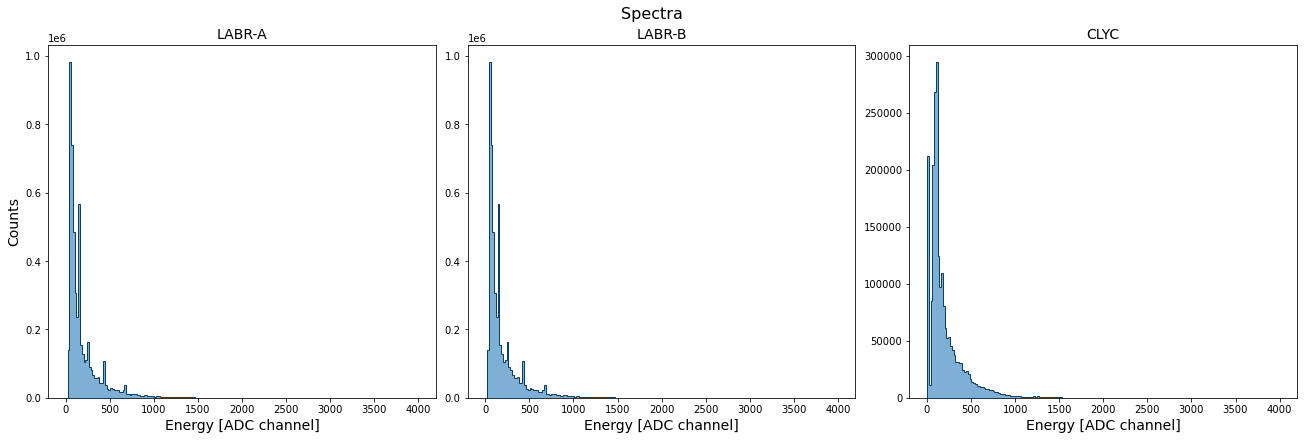

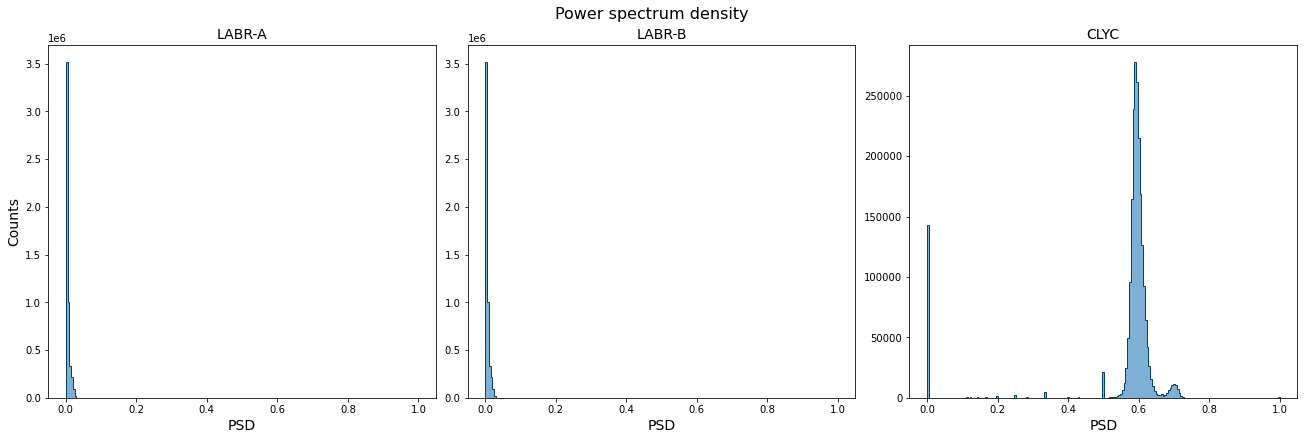

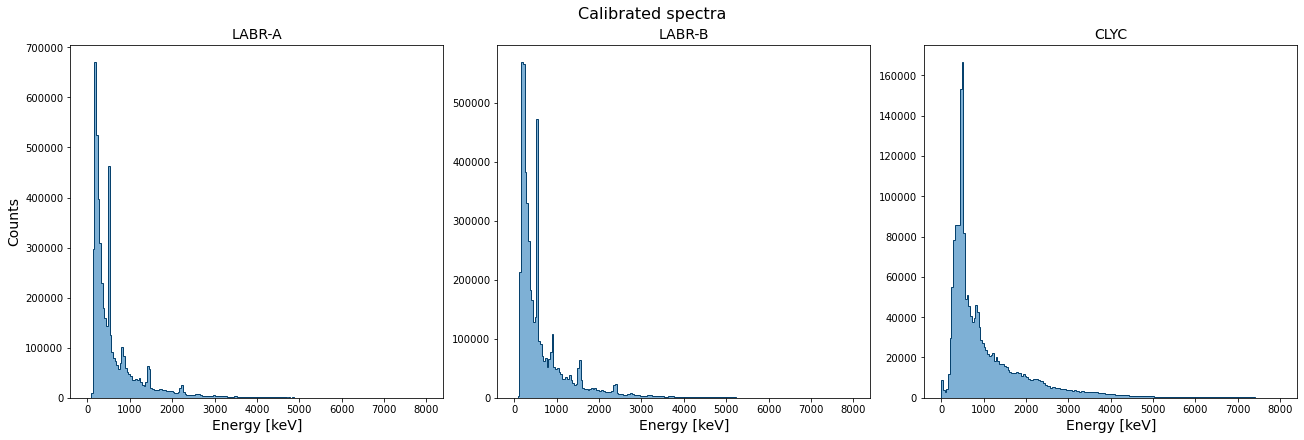

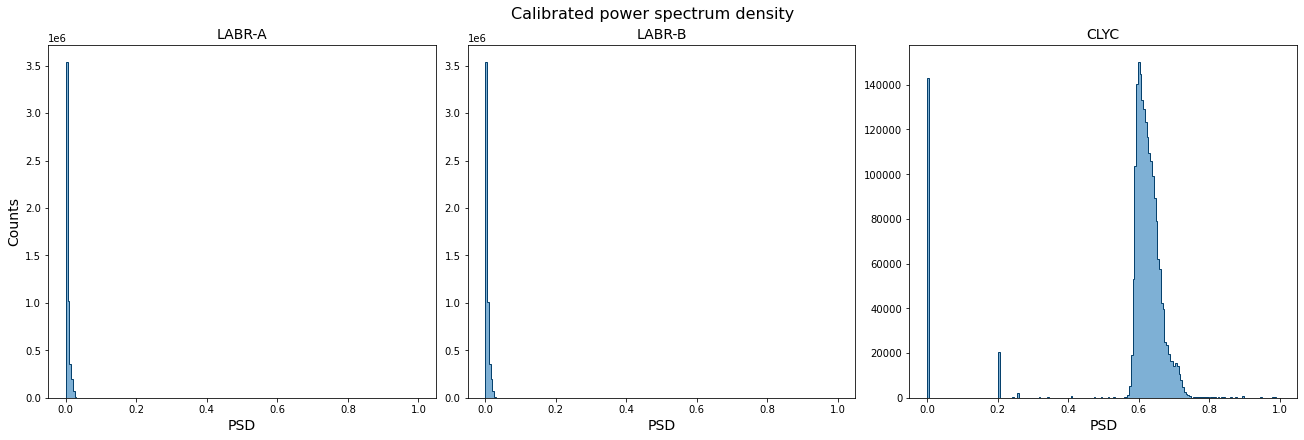

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True, sharex=True)

bins = np.linspace(0, 4000, 200)

ax[0].hist(data_labr_a["energy"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-A")
ax[1].hist(data_labr_b["energy"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-B")
ax[2].hist(data_clyc["energy"],   bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="CLYC")

fig.suptitle("Spectra", fontsize=16)
ax[0].set_title("LABR-A", fontsize=14)
ax[0].set_ylabel("Counts", fontsize=14)
ax[0].set_xlabel("Energy [ADC channel]", fontsize=14)
ax[1].set_title("LABR-B", fontsize=14)
ax[1].set_xlabel("Energy [ADC channel]", fontsize=14)
ax[2].set_title("CLYC", fontsize=14)
ax[2].set_xlabel("Energy [ADC channel]", fontsize=14)

plt.show()

fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True, sharex=True)

bins = np.linspace(0, 1, 200)

ax[0].hist(data_labr_a["psd"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-A")
ax[1].hist(data_labr_b["psd"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-B")
ax[2].hist(data_clyc["psd"],   bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="CLYC")

fig.suptitle("Power spectrum density", fontsize=16)
ax[0].set_title("LABR-A", fontsize=14)
ax[0].set_ylabel("Counts", fontsize=14)
ax[0].set_xlabel("PSD", fontsize=14)
ax[1].set_title("LABR-B", fontsize=14)
ax[1].set_xlabel("PSD", fontsize=14)
ax[2].set_title("CLYC", fontsize=14)
ax[2].set_xlabel("PSD", fontsize=14)

plt.show()


fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True, sharex=True)

bins = np.linspace(0, 8000, 200)

ax[0].hist(data_labr_a["energy_calib"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-A")
ax[1].hist(data_labr_b["energy_calib"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-B")
ax[2].hist(data_clyc["energy_calib"],   bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="CLYC")

fig.suptitle("Calibrated spectra", fontsize=16)
ax[0].set_title("LABR-A", fontsize=14)
ax[0].set_ylabel("Counts", fontsize=14)
ax[0].set_xlabel("Energy [keV]", fontsize=14)
ax[1].set_title("LABR-B", fontsize=14)
ax[1].set_xlabel("Energy [keV]", fontsize=14)
ax[2].set_title("CLYC", fontsize=14)
ax[2].set_xlabel("Energy [keV]", fontsize=14)

plt.show()

fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True, sharex=True)

bins = np.linspace(0, 1, 200)

ax[0].hist(data_labr_a["psd_calib"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-A")
ax[1].hist(data_labr_b["psd_calib"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-B")
ax[2].hist(data_clyc["psd_calib"],   bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="CLYC")

fig.suptitle("Calibrated power spectrum density", fontsize=16)
ax[0].set_title("LABR-A", fontsize=14)
ax[0].set_ylabel("Counts", fontsize=14)
ax[0].set_xlabel("PSD", fontsize=14)
ax[1].set_title("LABR-B", fontsize=14)
ax[1].set_xlabel("PSD", fontsize=14)
ax[2].set_title("CLYC", fontsize=14)
ax[2].set_xlabel("PSD", fontsize=14)

plt.show()

## PSD vs Energy for CLYC

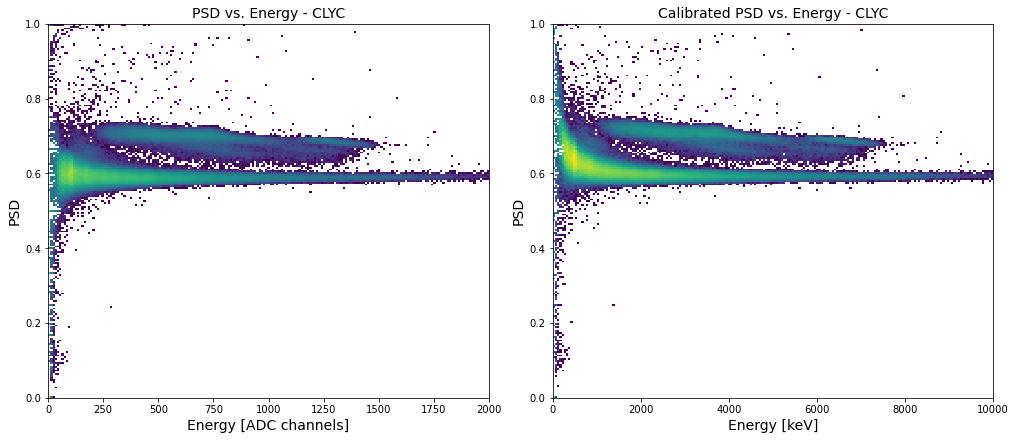

In [9]:
from matplotlib.colors import LogNorm


fig, ax = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

e_bins = np.linspace(0, 2000, 200)
psd_bins = np.linspace(0, 1, 200)

ax[0].hist2d(data_clyc["energy"], data_clyc["psd"], bins=(e_bins, psd_bins), cmap="viridis", norm=LogNorm())
ax[0].set_title("PSD vs. Energy - CLYC", fontsize=14)
ax[0].set_xlabel("Energy [ADC channels]", fontsize=14)
ax[0].set_ylabel("PSD", fontsize=14)

e_bins = np.linspace(0, 10000, 200)
psd_bins = np.linspace(0, 1, 200)

ax[1].hist2d(data_clyc["energy_calib"], data_clyc["psd_calib"], bins=(e_bins, psd_bins), cmap="viridis", norm=LogNorm())
ax[1].set_title("Calibrated PSD vs. Energy - CLYC", fontsize=14)
ax[1].set_xlabel("Energy [keV]", fontsize=14)
ax[1].set_ylabel("PSD", fontsize=14)

plt.show()

## Particle Identification

In [10]:
data = np.array([data_labr_a["energy"], data_labr_a["psd"]]).T
data.shape

(5233096, 2)

In [11]:
# # Create a DBSCAN object 
# optics = OPTICS(min_samples=0.35, max_eps=1, xi=.05, min_cluster_size=.05, cluster_method="dbscan", n_jobs=-1)

# # Fit the DBSCAN model to the data
# optics.fit(data)

# # Get the cluster labels for each point
# labels = optics.labels_

# # Print the number of clusters and the number of noise points (points not assigned to any cluster)
# print(f"Number of clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")
# print(f"Number of noise points: {list(labels).count(-1)}")

In [12]:
import tensorflow as tf

# Create the model
input_dim = 2  # Number of input features
encoding_dim = 3  # Number of latent variables

# Encoder
inputs = tf.keras.Input(shape=(input_dim,))
encoded = tf.keras.layers.Dense(32, activation='relu')(inputs)
encoded = tf.keras.layers.Dense(16, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(8, activation='relu')(encoded)
latent = tf.keras.layers.Dense(encoding_dim)(encoded)

# Decoder
decoded = tf.keras.layers.Dense(8, activation='relu')(latent)
decoded = tf.keras.layers.Dense(16, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(32, activation='relu')(decoded)
outputs = tf.keras.layers.Dense(input_dim)(decoded)

# Create the autoencoder model
autoencoder = tf.keras.Model(inputs, outputs)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
autoencoder.fit(data, data, epochs=10, batch_size=data.shape[0]//50, shuffle=True, verbose=1)

# Extract the encoder model
encoder = tf.keras.Model(inputs, latent)

# Encode the test data
encoded_test_data = encoder.predict(data)

# Perform clustering on the encoded test data
from sklearn.cluster import KMeans, MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=2, batch_size=1024*8, njobs=8, )
clusters = kmeans.fit_predict(encoded_test_data)

# Visualize the clusters
import matplotlib.pyplot as plt
plt.scatter(encoded_test_data[:, 0], encoded_test_data[:, 1], c=clusters)
plt.show()


2022-12-16 22:06:08.437771: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-16 22:06:08.437891: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-16 22:06:08.627194: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/10


2022-12-16 22:06:08.799978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 5s 97ms/step - loss: 38799.5547
Epoch 2/10
51/51 [==============================] - 5s 95ms/step - loss: 8231.8223
Epoch 3/10
51/51 [==============================] - 5s 95ms/step - loss: 7003.9839
Epoch 4/10
51/51 [==============================] - 5s 94ms/step - loss: 6997.0845
Epoch 5/10
51/51 [==============================] - 5s 94ms/step - loss: 6960.5547
Epoch 6/10
51/51 [==============================] - 5s 94ms/step - loss: 5173.6626
Epoch 7/10
51/51 [==============================] - 5s 94ms/step - loss: 97.5135
Epoch 8/10
51/51 [==============================] - 5s 95ms/step - loss: 5.2950
Epoch 9/10
51/51 [==============================] - 5s 95ms/step - loss: 4.8490
Epoch 10/10
51/51 [==============================] - 5s 96ms/step - loss: 4.6808


2022-12-16 22:06:57.525456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 